<a href="https://colab.research.google.com/github/nghess/micrograd/blob/main/micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def f(x):
  return 3*x**2 - 4*x + 5

In [ ]:
f(3.0)

20.0

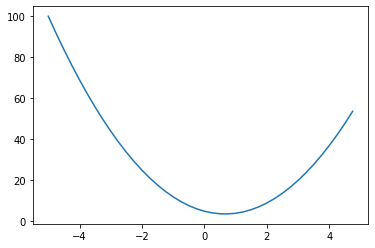

In [ ]:
xs = np.arange(-5, 5, .25)
ys = f(xs)
plt.plot(xs, ys)
       

In [ ]:
# Simple derivative example
h = .001
x = 3.0
# Calculate the derivative at 3
(f(x + h) - f(x))/h  # Normalize over the run (h) to get the slope

14.00300000000243

In [ ]:
# More complex derivative example
a = 2.0
b = -3.0
c = 10.0
d = a*b + c

# Caclulating d with respect to a
d1 = a*b + c 
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 3.997
slope -3.0000000000001137


In [ ]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    def _backward():
      self.grad = (1 - t**2) * out.grad
    out._backward = _backward
    return out
  
  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f ; L.label = 'L'

In [ ]:
from graphviz import Digraph

def trace(root):
  # Builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # For any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation,  create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this not to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

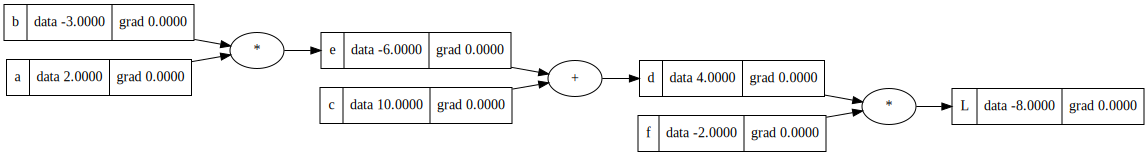

In [ ]:
draw_dot(L)

In [ ]:
# Derivates (chain rule)
L.grad = 1.0
f.grad = 4.0  # dL/df = Value of d
d.grad = -2.0  # dL/dd = Value of f 
e.grad = -2.0  # dL/de = dd/de * dL/df = 1.0 * -2.0
c.grad = -2.0
b.grad = -4.0
a.grad = 6.0

In [ ]:
a.data += .01 * a.grad
b.data += .01 * b.grad
c.data += .01 * c.grad
f.data += .01 * f.grad

e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
L = d * f ; L.label = 'L'

print(L.data)

-7.286496


In [ ]:
def lol():
  h = .0001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f ; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f ; L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)

lol()

0.0


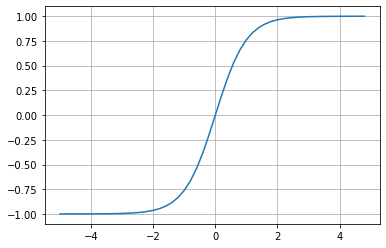

In [ ]:
plt.plot(np.arange(-5,5,.2,), np.tanh(np.arange(-5,5,.2))); plt.grid()

In [ ]:
# Inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# Bias
b = Value(6.8813725870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label= 'x1*w1'
x2w2 = x2*w2; x2w2.label= 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

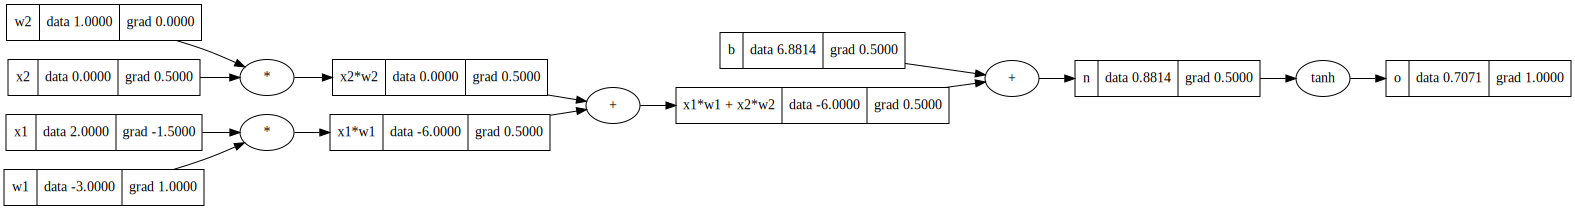

In [ ]:
draw_dot(o)

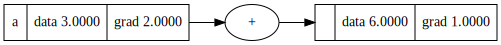

In [ ]:
a = Value(3.0, label='a')
b = a + a
b.backward()
draw_dot(b)

In [ ]:
# Automated backprop
o.backward()

In [ ]:
# Manual backprop
#o.grad = 1.0
#n.grad = 1 - o.data**2  #.5
#x1w1x2w2.grad = .5
#x1w1.grad = .5
#x2w2.grad = .5
#w1.grad = x1.data * x1w1.grad
#x1.grad = w1.data * x1w1.grad
#w2.grad = x2.data * x2w2.grad
#x2.grad = w2.data * x2w2.grad
